In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [17]:
NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

In [18]:
threshold = 0.4
column_to_predict = "kg_CO2/kWh"

independent_variables = []


for column in train:
    if abs(train[column].corr(train[column_to_predict])) > threshold:
        independent_variables.append(column)

# independent_variables.remove(column_to_predict)
if "Index" in independent_variables:
    independent_variables.remove("Index")
independent_variables

['Hour_1',
 'Hour_2',
 'Hour_3',
 'Occupant Count (people)_3',
 '12h Outdoor Drybulb Temperature (C)',
 '24h Outdoor Drybulb Temperature (C)',
 '12h Outdoor Relative Humidity (%)',
 '6h Direct Solar Radiation (W/m2)',
 '12h Direct Solar Radiation (W/m2)',
 'kg_CO2/kWh']

In [19]:
X_train = train[independent_variables]
# X_train = train[["Hour_1", "Day Type_1"]]
Y_train = train[column_to_predict]

X_train.head()
rows, num_of_columns = X_train.shape

In [20]:
def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        #print(f"i = {i}, seq = {seq}")
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        #print(f"i = {i}, target = {target}")
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [21]:
input_sequences, target_variables = create_sequences(X_train, Y_train, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
print(input_sequences[0])
print(target_variables[0])
print(input_sequences.shape)
print(target_variables.shape)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  8.40305674e-01 3.41110874e-01 2.84653240e-01 1.35680787e-01
  9.03531290e-01 2.97294973e-01]
 [4.34782609e-02 4.34782609e-02 4.34782609e-02 1.00000000e+00
  8.35694132e-01 1.31464429e-01 2.36547501e-01 2.84342677e-01
  7.30342170e-01 2.06405263e-01]
 [8.69565217e-02 8.69565217e-02 8.69565217e-02 1.00000000e+00
  8.75367853e-01 1.38832035e-01 1.41625263e-01 1.86201506e-01
  8.74456687e-01 1.46160546e-01]
 [1.30434783e-01 1.30434783e-01 1.30434783e-01 1.00000000e+00
  9.60540996e-01 2.93742444e-01 1.57973161e-01 4.40658779e-01
  7.56219376e-01 1.34989510e-01]
 [1.73913043e-01 1.73913043e-01 1.73913043e-01 5.00000000e-01
  9.02450503e-01 1.80204520e-01 1.77644208e-01 5.38847476e-01
  8.33149859e-01 1.67124490e-01]
 [2.17391304e-01 2.17391304e-01 2.17391304e-01 5.00000000e-01
  8.54914265e-01 2.18826081e-01 1.59108714e-01 8.63126113e-01
  4.14593785e-01 2.18208263e-01]
 [2.60869565e-01 2.60869565e-01 2.60869565e-01 5.00000000e

In [22]:
# importing libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.optimizers import SGD

In [33]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = 4) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 5) #patience parameter to be adjusted

loss = []
val_loss = []

for train_data, test_data in tscv.split(input_sequences):
    X_train, X_test = input_sequences[train_data], input_sequences[test_data]
    y_train, y_test = target_variables[train_data], target_variables[test_data]
    
    model = keras.Sequential([
        
        # TODO I think this might be needed to group by timestamps rather than variables
        keras.layers.Permute((2,1), input_shape=(48,num_of_columns)),
        
        # include a flatten layer to convert to 1D (used as a first layer instead of reshaping)
        keras.layers.Flatten(input_shape=(num_of_columns,48)),
        # shape should be vertically, so 48 data points for x1, then x2...
        keras.layers.Dense(1200, activation='tanh'),
        # keras.layers.Dropout(0.2),   no dropout yet
        keras.layers.Dense(600, activation='tanh'),
        keras.layers.Dense(240, activation='tanh'),
        keras.layers.Dense(24)
    ]) #amount of layers & neurons to be adjusted


    model.compile(
        optimizer='adam',
        loss= 'mse'
    ) #types of optimizer, loss function to be adjusted
    
    history = model.fit(X_train, y_train,
              epochs=200, 
              validation_data=(X_test, y_test),
              # validation_split = 0.8,
              verbose=1,
              #callbacks=callback
    )
    
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])

Epoch 1/200
4/4 [==============================] - 1s 48ms/step - loss: 1.2609 - val_loss: 0.2470
Epoch 2/200
4/4 [==============================] - 0s 22ms/step - loss: 0.2122 - val_loss: 0.0994
Epoch 3/200
4/4 [==============================] - 0s 21ms/step - loss: 0.0711 - val_loss: 0.0674
Epoch 4/200
4/4 [==============================] - 0s 21ms/step - loss: 0.0499 - val_loss: 0.0548
Epoch 5/200
4/4 [==============================] - 0s 20ms/step - loss: 0.0342 - val_loss: 0.0408
Epoch 6/200
4/4 [==============================] - 0s 18ms/step - loss: 0.0293 - val_loss: 0.0393
Epoch 7/200
4/4 [==============================] - 0s 18ms/step - loss: 0.0239 - val_loss: 0.0409
Epoch 8/200
4/4 [==============================] - 0s 18ms/step - loss: 0.0207 - val_loss: 0.0456
Epoch 9/200
4/4 [==============================] - 0s 19ms/step - loss: 0.0199 - val_loss: 0.0417
Epoch 10/200
4/4 [==============================] - 0s 22ms/step - loss: 0.0174 - val_loss: 0.0362
Epoch 11/200
4/4 [=

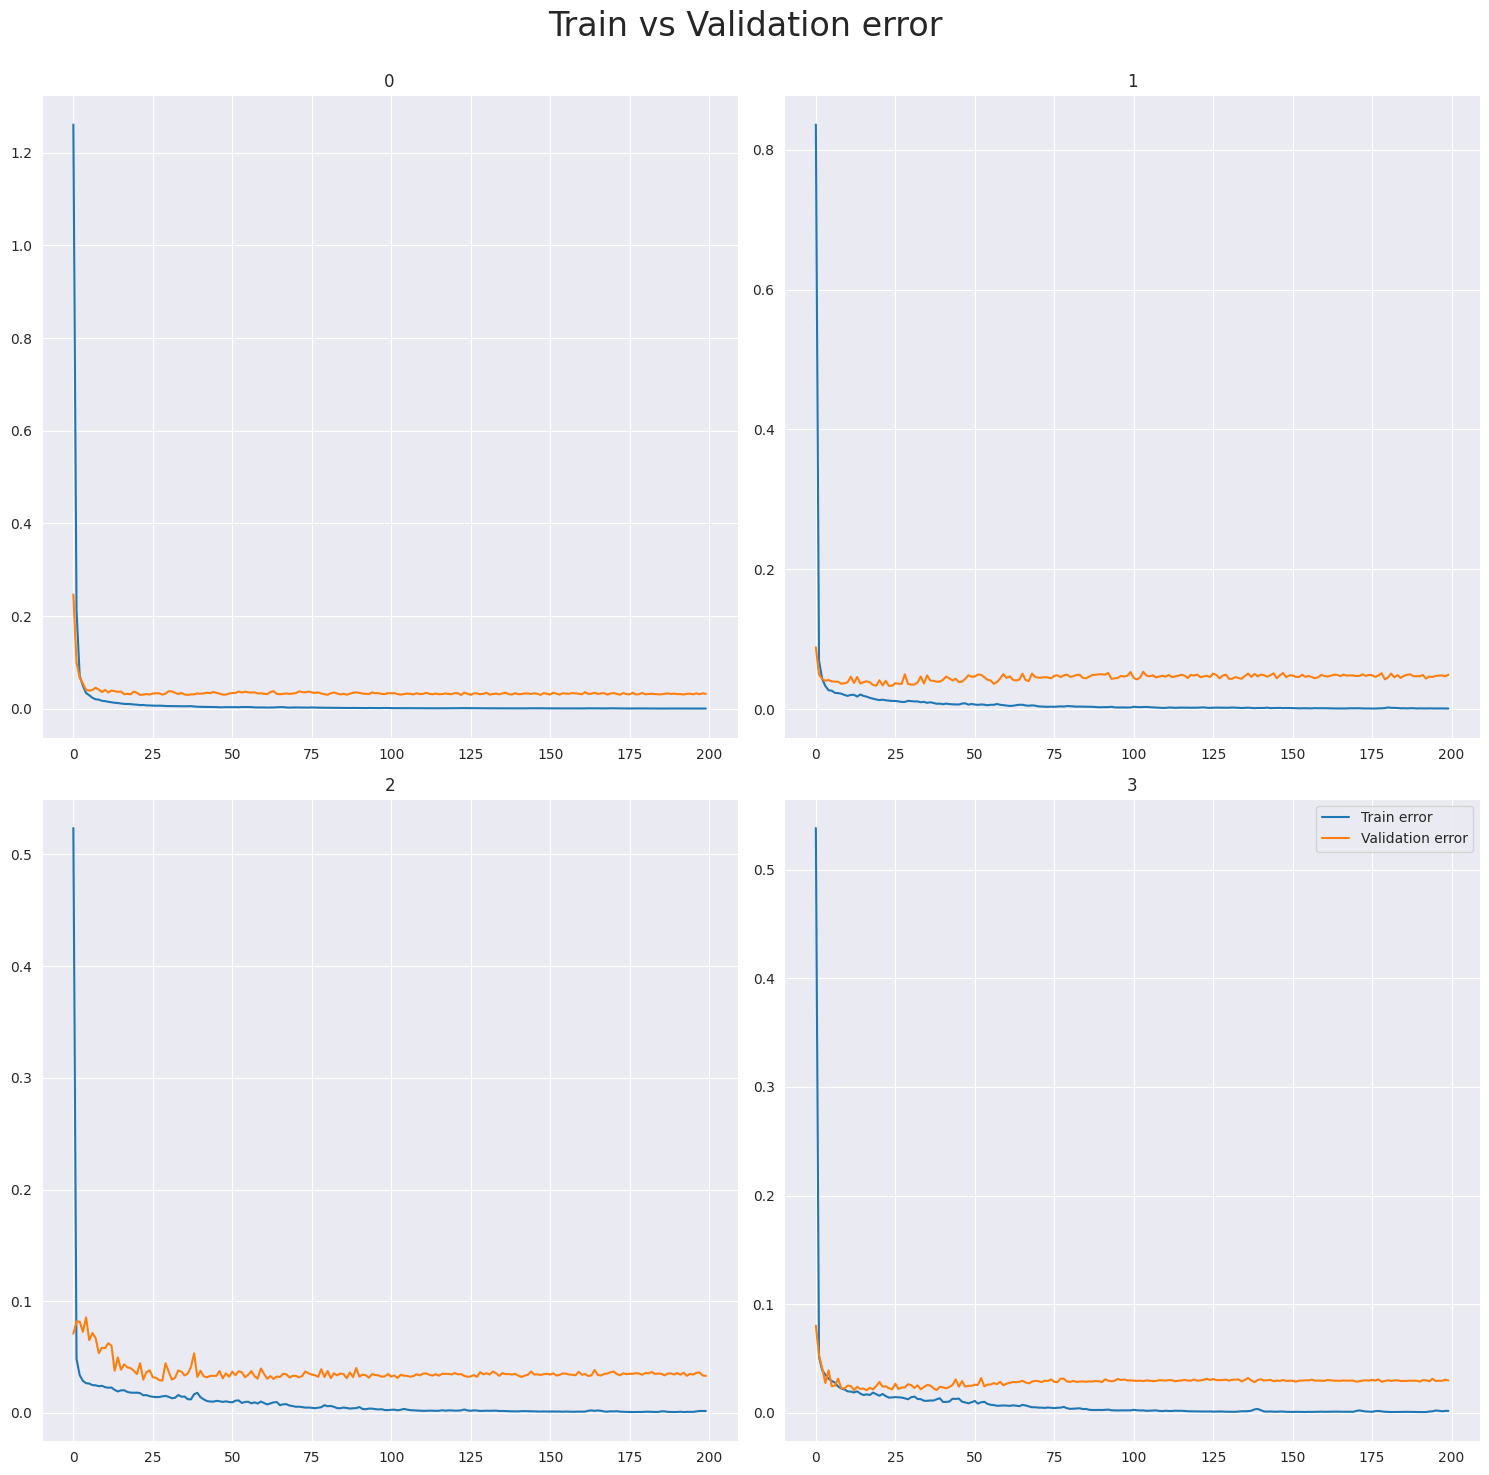

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()